In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'alzheimers-dataset-4-class-of-images:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F457093%2F861496%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240625%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240625T113202Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0b8a807025c822f6bc98fc229011747f1fc06d70ca0bd9ba1c4ff6af7ef345ec07e256eb649e1e7a42439274ba6fbdb9525a41db6be2a23496f530b5b6f79895a70c55849142e3dc247859c0505d83d38bb0282a7c2151694f833c94cbb74fb9d4cfc4ddd63be0e8c2918027e67afdaa8fe419af6a8ae51aa19be6e61e9416b37089670758f796d82f952ceed8311625477c35f46a5d808550cd49ab2a9c9a0ab8f112ffbe18522a0b2629553b3d4c04664e181c4bbe05dff84da897c99a1f3653187589d4489417ab3b37bb35aa2d6d21dbe7d84882884d768e3d78700298dc2b6c0c52e4c21e4973a28707d0faaf55356445cbb913d6b7679ccd5ac796f9e3'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 35779075 bytes downloaded
Downloaded and uncompressed: alzheimers-dataset-4-class-of-images
Data source import complete.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from torchvision.utils import make_grid

### Doing some transformation to the dataset like normalization, resizing, grayscaling

In [ ]:
# transformation to the image dataseet:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to a fixed size
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()           # Convert images to PyTorch tensors and scale to [0, 1]
])


### Specifying the path to the dataset.
### Below is the path of the kaggle dataset hosted on kaggle (please, use it if you run the notebook on kaggle notebook).
#### If you run the notebook on other platforms, you need to modify the path.

In [ ]:
train_dir = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/"


In [ ]:
test_dir = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/"

#### Applying the already definded transformation to the dataset

In [ ]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)


In [ ]:
test_dataset = datasets.ImageFolder(test_dir, transform=transform)


####  Loading the training dataset in a way that optimizes the training process

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


#### Get one batch of images and Visualizae sample images

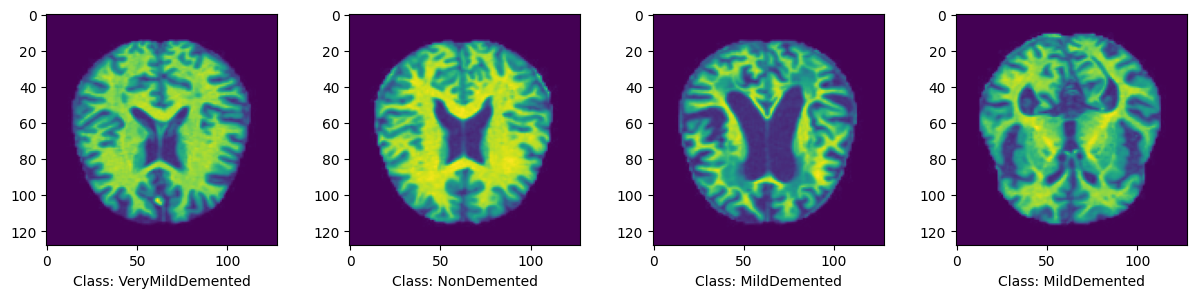

In [ ]:
# Get one batch of images
images, labels = next(iter(train_loader))

# Number of images you want to display
num_images = 4

# Create a grid for the images
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

class_names = train_dataset.classes

for i in range(num_images):
    # Convert image tensor to numpy array and transpose the axes
    # PyTorch tensors are in (C, H, W) format, and Matplotlib expects (H, W, C)
    img = images[i].numpy().transpose(1, 2, 0)
    axes[i].imshow(img)
    axes[i].axis('on')  # Turn off axis
    axes[i].set_xlabel(f'Class: {class_names[labels[i].item()]}') # Set the label as x-axis label

plt.show()

## Number of images in each class (Histogram).

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


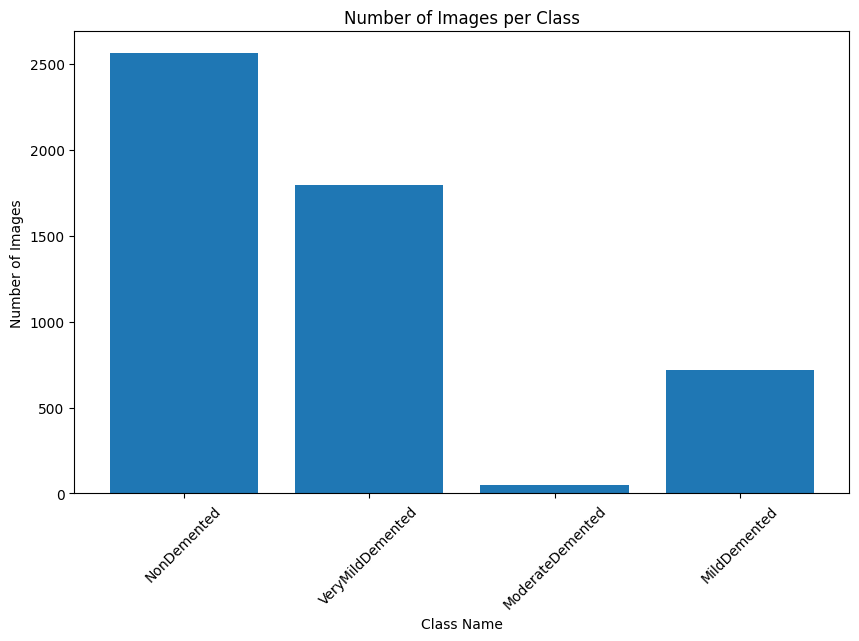

In [ ]:
class_names = train_dataset.classes
print(class_names)

# Initialize a Counter to hold the count of each class
class_counts = Counter()
# Iterate over the DataLoader to count labels
for _, labels in train_loader:
    class_counts.update(labels.tolist())

# Convert the counts to lists for plotting
class_indices, counts = zip(*class_counts.items())
class_labels = [class_names[i] for i in class_indices]

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(class_labels, counts, align='center')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)  # Rotate class names for better readability
plt.title('Number of Images per Class')
plt.show()

### The number of images in each class

In [ ]:
class_counts = Counter([label for _, label in train_dataset])

# Print the class name and the number of images in each class
for class_index, count in class_counts.items():
    print(f"{train_dataset.classes[class_index]}: {count}")

MildDemented: 717
ModerateDemented: 52
NonDemented: 2560
VeryMildDemented: 1792


### Utility function (helper) to get the size of the flattened output to prepare it to the dense layer.
#### This function assumes you have two convolutional layers and max pooling(downsampling) after each convolutioonal layer.
#### In case you want to add more conv layers, you need to modify this function before.
    



In [ ]:
def calculate_flattened_output(input_size, input_channels,
                               conv1_filter_size, conv1_filters, conv1_stride,
                               conv2_filter_size, conv2_filters, conv2_stride,
                               pool_size, pool_stride):
    # Function to calculate output size of conv layer
    def conv_output_size(size, filter_size, stride):
        return (size - filter_size) // stride + 1

    # Function to calculate output size of pool layer
    def pool_output_size(size, pool_size, pool_stride):
        return (size - pool_size) // pool_stride + 1

    # Calculate output size after each layer
    conv1_output = conv_output_size(input_size, conv1_filter_size, conv1_stride)
    pool1_output = pool_output_size(conv1_output, pool_size, pool_stride)

    conv2_output = conv_output_size(pool1_output, conv2_filter_size, conv2_stride)
    pool2_output = pool_output_size(conv2_output, pool_size, pool_stride)

    # Calculate flattened output size
    flattened_output = pool2_output * pool2_output * conv2_filters
    return flattened_output

# Example call
output_size = calculate_flattened_output(128, 1, 3, 16, 1, 3, 32, 1, 2, 2)
print(output_size)


28800


## Building the CNN architecture:
### - Convolutional layer:
####  serves the purpose of extracting features from input images. It applies filters (also known as kernels) to the input image to create feature maps
### - Pooling:
####  reduces the spatial size of feature maps. It helps in making the detection of features             invariant to scale and orientation changes.
### - Activation Function:
####   It introduces non-linearity to the model, which is essential for learning complex patterns          in data.
### - Flattening:
####  is used to convert the multi-dimensional output of the preceding layers (like convolutional         and pooling layers) into a one-dimensional array
### - Dense Layers (Fully Connected FC):
####  The purpose of these layers is to perform high-level reasoning from the features extracted by        previous layers. Dense layers are where the network combines these features to make final          predictions or decisions, such as classifying an image.

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 30 * 30, 64)  # Adjusted size
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, 4)  # Assuming 4 classes

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 32 * 30 * 30)  # Adjusted size
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x


### Spliting the dataset (train folder) into training and validating data.
#### This technique is called *Cross Validation* CV and commonly used as it helps to address the issue of overfitting.
#### *Overfitting* is a problem when the model performs well on the training data but very baddly on unforseen data.

In [ ]:
# Split the dataset into training and validation sets (80-20 split)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data= torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [ ]:
# Create data loaders
batch_size = 4
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)

In [ ]:
# Initialize the model
model = SimpleCNN()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=28800, out_features=64, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)

In [ ]:
import torch.nn.functional as F

best_val_loss = float('inf')
patience = 5  # Number of epochs to wait for improvement before stopping
patience_counter = 0
train_losses = []
val_losses = []
val_accuracies = []
all_preds = []
all_labels = []
num_epochs=10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    model.eval()
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = val_corrects.double() / len(val_loader.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset counter
        # Optionally save the model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    # Early stopping check
    if patience_counter >= patience:
        print("Stopping early due to no improvement in validation loss.")
        break

Epoch 1/10, Train Loss: 0.9403, Val Loss: 0.8406, Val Accuracy: 0.5990243902439024
Epoch 2/10, Train Loss: 0.5992, Val Loss: 0.4032, Val Accuracy: 0.8282926829268292
Epoch 3/10, Train Loss: 0.2438, Val Loss: 0.6168, Val Accuracy: 0.7141463414634146
Epoch 4/10, Train Loss: 0.1068, Val Loss: 0.0919, Val Accuracy: 0.9668292682926829
Epoch 5/10, Train Loss: 0.0578, Val Loss: 0.0749, Val Accuracy: 0.9765853658536585
Epoch 6/10, Train Loss: 0.0370, Val Loss: 0.0730, Val Accuracy: 0.9795121951219512
Epoch 7/10, Train Loss: 0.0317, Val Loss: 0.0789, Val Accuracy: 0.9746341463414634
Epoch 8/10, Train Loss: 0.0274, Val Loss: 0.0766, Val Accuracy: 0.9707317073170731
Epoch 9/10, Train Loss: 0.0275, Val Loss: 0.3033, Val Accuracy: 0.8926829268292683
Epoch 10/10, Train Loss: 0.0243, Val Loss: 0.1423, Val Accuracy: 0.9463414634146341


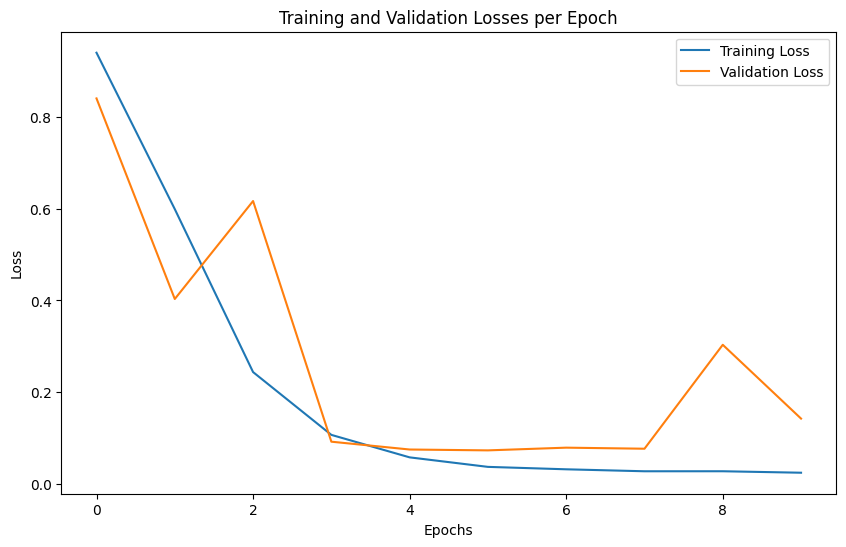

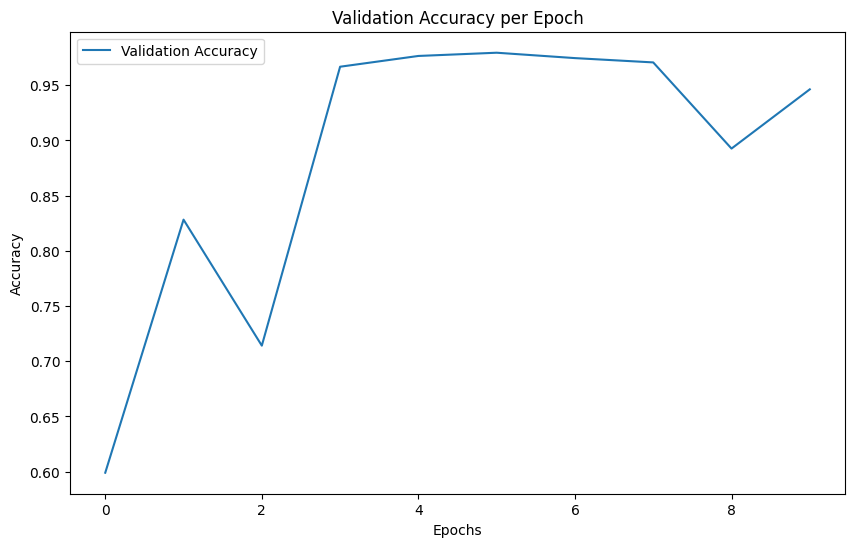

In [ ]:
import matplotlib.pyplot as plt

# Convert tensor data to CPU before plotting
train_losses = [loss for loss in train_losses]  # Assuming train_losses are already in a list of floats
val_losses = [loss for loss in val_losses]  # Assuming val_losses are already in a list of floats
val_accuracies = [accuracy.cpu().numpy() for accuracy in val_accuracies]  # Convert to CPU and then to numpy

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Training and Validation Losses per Epoch")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Validation Accuracy per Epoch")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


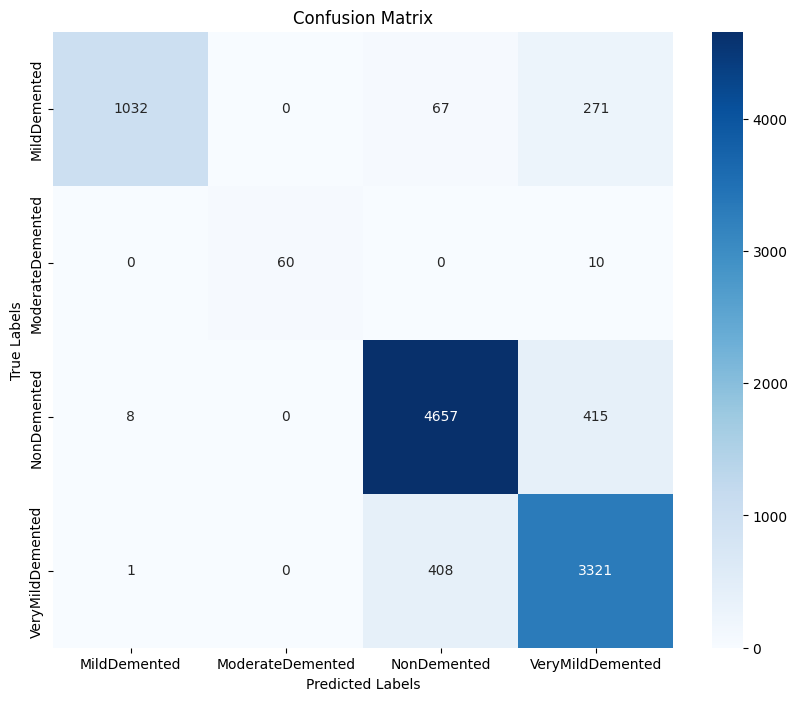

In [ ]:
# Calculate the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(all_labels, all_preds)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'AD_cnn_model.pth')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score


# Storage for predictions and actual labels
all_preds = []
all_labels = []

# Evaluation loop
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to arrays for metric calculation
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate metrics for each class
for class_index in range(4):  # Replace num_classes with the actual number of classes
    class_preds = (all_preds == class_index)
    class_labels = (all_labels == class_index)
    accuracy = accuracy_score(class_labels, class_preds)
    precision = precision_score(class_labels, class_preds, zero_division=0)
    recall = recall_score(class_labels, class_preds, zero_division=0)

    class_name = class_names[class_index]

    print(f"Class name {class_name}({class_index}) - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")

cm = confusion_matrix(all_labels, all_preds)
print(cm)

Class name MildDemented(0) - Accuracy: 0.8678655199374511, Precision: 0.5833333333333334, Recall: 0.19553072625698323
Class name ModerateDemented(1) - Accuracy: 0.9921813917122753, Precision: 1.0, Recall: 0.16666666666666666
Class name NonDemented(2) - Accuracy: 0.6059421422986708, Precision: 0.7786885245901639, Recall: 0.296875
Class name VeryMildDemented(3) - Accuracy: 0.5285379202501954, Precision: 0.42034943473792397, Recall: 0.9129464285714286
[[ 35   0  24 120]
 [  0   2   0  10]
 [ 16   0 190 434]
 [  9   0  30 409]]


### And finally how to test on unforseen image:

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to the same size as training images
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor()  # Convert to PyTorch tensor
])

# Load the saved model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 30 * 30, 64)  # Adjusted size
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, 4)  # Assuming 4 classes

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 32 * 30 * 30)  # Adjusted size
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model and load the weights
model = SimpleCNN()
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load and preprocess the image
image_path = "/content/sample_data/mildDem10.jpg"  # Replace with the path to your image
image = Image.open(image_path)
image = transform(image).unsqueeze(0).to(device)  # Apply transformations and add batch dimension

# Predict the class
with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output, 1)

# Get the class names
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']  # Replace with your actual class names

# Print the prediction
predicted_class = class_names[predicted.item()]
print(f"The predicted class for the image is: {predicted_class}")


The predicted class for the image is: MildDemented
